## Looking to analyze ripples during catFR when the same category is reinstated during encoding

In [2]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

import seaborn as sb

df = get_data_index("r1") # all RAM subjects
exp = 'catFR1' # 'FR1' 'catFR1'

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/timeseries.py:526: FutureWarning: xarray subclass TimeSeriesX should explicitly define __slots__
  class TimeSeriesX(TimeSeries):
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# sub lists I've been using to explore FR1 

subs = ['R1010J'] #'R1385E'] # ['R1065J'] #
# subs = ['R1002P','R1003P','R1006P','R1010J','R1112M','R1163T'] # initial 6 for hippocampus

# subs = subs+['R1001P','R1092J','R1151E','R1320D'] # additional subs with issues that I resolved with various RR and corr thresholds
# subs = ['R1112M','R1018P','R1020J','R1022J','R1023J','R1026D','R1027J'] # 7 with entorhinal
# subs = ['R1010J','R1112M'] # original 2 # R1108J beatiful catFR1 data; R1065J magical subject (like with FR1)
# subs = ['R1112M','R1163T'] # subjects with FR1 and catFR1. SRs of 1000 and 500 tho
# subs = ['R1151E'] # all channels X sessions get removed but 3 after 60/180 hz line removal
# these should all be worked out now. See SWR FR1 problem sessions PPT on Box for details of each
# subs = ['R1299T','R1332M','R1397D','R1349T','R1339D','R1337E','R1275D','R1151E','R1123C','R1120E','R1045E'] # final surrounding_recall problem subs after looking at huge raster!
# subs = ['R1308T','R1338T','R1358T'] # these guys had weird SRs and some loading problems when I went to whole_retrieval analysis...fixed with rounding
# subs = ['R1023J','R1101T','R1148P','R1368T','R1323T','R1334T'] # single session subs with memory allocation errors in ClusterRun
# subs = ['R1006P','R1010J','R1030J','R1032D','R1049J','R1051J','R1052E','R1054J','R1093J','R1098D','R1104D','R1108J','R1111M',
#         'R1115T','R1118N','R1124J','R1207J','R1230J','R1316T','R1329T','R1323T','R1337E','R1367D'] # subs that didn't load on 2020-07-04 encoding run
# subs = ['R1368T','R1461T','R1463E'] # subs with particularly low localization.pair matches in pairs...see Excel in loading info on Box for details
subs = ['R1433E','R1355T','R1367D','R1368T'] # subs with "ca3" or "dg"
# subs = ['R1001P'] # subject with over 8000 FR1 trials X electrodes
# bad_subs = ['R1433E','R1051J'] # no electrode cats
# subs = ['R1379E','R1385E','R1387E','R1394E','R1402E'] # partial beep subs
# subs = ['R1379E','R1402E','R1396T','R1395M','R1415T','R1389J','R1404E']  # test subs for eeg offset correction
# subs = ['R1054J','R1345D','R1048E','R1328E','R1308T', # first 2 are sr ≥ 1000. 3rd is 500 Hz.
#         'R1137E','R1136N','R1094T','R1122E','R1385E', # nice example FR1 subs used in Fig. 2
#         'R1405E','R1486J','R1501J'] # adding in 3 catFR only patients that will go into Fig. 4
# subs = ['R1120E','R1349T','R1397D','R1332M','R1299T'] # FR1 patients with electrode search ranges limited per SWR problem sessions doc on Box
# subs = ['R1269E','R1328E','R1367D','R1397D','R1405E','R1405E','R1447M','R1469D'] # catFR1 patients with electrode search changes limited
subs = ['R1405E']

sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # all sessions for subs
# sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp) & (df.session==1)] # single session
# sub_df = df[(df.experiment == exp) & (df.session == 0)] # all FR subs 
sub_df = sub_df[0:1]
sub_df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
2011,NaN,protocols/r1/subjects/R1405E/experiments/catFR...,protocols/r1/subjects/R1405E/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1405E/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1405E/localizations/0/m...,NaN,0,R1405E,R1405E,3.3,protocols/r1/subjects/R1405E/experiments/catFR...


In [4]:
# 575 FR sessions. first 18 of don't load so skip those 
exp_df = df[df.experiment==exp]
if exp == 'FR1':
    exp_df = exp_df[
                    ((df.subject!='R1015J') | (df.session!=0)) & 
                    ((df.subject!='R1063C') | (df.session!=1)) & 
                    ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
                    ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1120E') | (df.session!=0)) &
                    ((df.subject!='R1122E') | (df.session!=2)) &
                    ((df.subject!='R1154D') | (df.session!=0)) &
                    ((df.subject!='R1186P') | (df.session!=0)) &
                    ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
                    ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1277J') | (df.session!=0)) &
                    ((df.subject!='R1413D') | (df.session!=0)) & 
                    ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                    ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                    ((df.subject!='R1275D') | (df.session!=3))  # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
    #                 (df.subject!='R1065J') # sub with 9000 trials
                   ] 
if exp == 'catFR1': 
    exp_df = exp_df[
                    ((df.subject!='R1044J') | (df.session!=0)) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1491T') | (~df.session.isin([1,3,5]))) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1486J') | (~df.session.isin([4,5,6,7]))) & # repeated data...will be removed at some point... @@
                    ((df.subject!='R1501J') | (~df.session.isin([0,1,2,3,4,5]))) & # these weren't catFR1 (and they don't load right anyway)
                    ((df.subject!='R1235E') | (df.session!=0)) & # split EEG filenames error...documented on Asana
                    ((df.subject!='R1310J') | (df.session!=1)) & # session 1 is just a repeat of session 0
                    ((df.subject!='R1239E') | (df.session!=0)) # some correlated noise (can see in catFR1 problem sessions ppt)
    ]
exp_df.shape
# exp_df = exp_df[257:] # for catFR1 this is R1385E-onwwards
# exp_df = exp_df[472:] # for FR1 this is R1385E-onwwards
# exp_df = exp_df[:50]
exp_df

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(503, 17)

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
24,NaN,protocols/r1/subjects/R1004D/experiments/catFR...,protocols/r1/subjects/R1004D/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1004D/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1004D/localizations/0/m...,NaN,0,R1004D,R1004D,NaN,protocols/r1/subjects/R1004D/experiments/catFR...
45,NaN,protocols/r1/subjects/R1013E/experiments/catFR...,protocols/r1/subjects/R1013E/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1013E/experiments/catFR...,1,NaN,0,protocols/r1/subjects/R1013E/localizations/0/m...,NaN,0,R1013E,R1013E_1,NaN,protocols/r1/subjects/R1013E/experiments/catFR...
58,NaN,protocols/r1/subjects/R1015J/experiments/catFR...,protocols/r1/subjects/R1015J/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1015J/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1015J/localizations/0/m...,NaN,0,R1015J,R1015J,NaN,protocols/r1/subjects/R1015J/experiments/catFR...
64,NaN,protocols/r1/subjects/R1016M/experiments/catFR...,protocols/r1/subjects/R1016M/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1016M/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1016M/localizations/0/m...,NaN,0,R1016M,R1016M,NaN,protocols/r1/subjects/R1016M/experiments/catFR...
65,NaN,protocols/r1/subjects/R1016M/experiments/catFR...,protocols/r1/subjects/R1016M/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1016M/experiments/catFR...,0,NaN,1,protocols/r1/subjects/R1016M/localizations/0/m...,NaN,1,R1016M,R1016M,NaN,protocols/r1/subjects/R1016M/experiments/catFR...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2473,NaN,protocols/r1/subjects/R1541T/experiments/catFR...,protocols/r1/subjects/R1541T/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1541T/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1541T/localizations/0/m...,NaN,3,R1541T,R1541T,3.4,protocols/r1/subjects/R1541T/experiments/catFR...
2474,NaN,protocols/r1/subjects/R1541T/experiments/catFR...,protocols/r1/subjects/R1541T/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1541T/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1541T/localizations/0/m...,NaN,4,R1541T,R1541T,3.4,protocols/r1/subjects/R1541T/experiments/catFR...
2475,NaN,protocols/r1/subjects/R1541T/experiments/catFR...,protocols/r1/subjects/R1541T/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1541T/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1541T/localizations/0/m...,NaN,6,R1541T,R1541T,3.4,protocols/r1/subjects/R1541T/experiments/catFR...
2490,NaN,protocols/r1/subjects/R1542J/experiments/catFR...,protocols/r1/subjects/R1542J/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1542J/experiments/catFR...,0,NaN,NaN,protocols/r1/subjects/R1542J/localizations/0/m...,NaN,0,R1542J,R1542J,3.4,protocols/r1/subjects/R1542J/experiments/catFR...


# Load CLUSTER data

In [5]:
## Now to load data from cluster, have to go through and append across sessions

### params that clusterRun used (note that exp is defined in first cell so can get exp_df above)

selected_period = 'encoding'
# 'whole_encoding': aligned to 1st word of each encoding period and ends 29.7 s later (average time for 12 words to be shown)
# 'encoding': aligned to word_on

recall_type_switch = 0

recall_minimum = 0 # used if recall_type_switch = 3
region_name = 'HPC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC # PHC 
remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###
filter_type = 'hamming' # butter/hamming/hamming125200/tried hamming140250 for math
sub_selection = 'first_half' # 'second_half', 'whole' ,'first_half'
                              # analyze first 40%, remaining 60% of data, or whole? 
                              # works for FR1 and catFR1
###

# get strings for path name for save and loading cluster data
if recall_type_switch in [0,4,6,8]:
    # for these I'm using all trials, but selecting for which recall after the fact
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,0,selected_period,recall_minimum)
else: # these others I haven't set up indexing (see >line 100 in this cell)
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
    
ripple_array = []; 
trial_nums = []; encoded_word_key_array = []
HPC_names = []; sub_sess_names = []
region_electrode_ct = []; sub_names = []
trial_by_trial_correlation = []; elec_ripple_rate_array = []
elec_by_elec_correlation = []; fr_array = []
list_num_key = []; category_array = [] # need these two to analyze categories during encoding

serialpos_array = []; list_recall_num_array = []; # ~~~
rectime_array = []; recall_before_intrusion_array = []
recall_position_array = []
semantic_clustering_key = []

electrode_labels = []; channel_coords = []; channel_nums = []

analysis_df = getSplitDF(exp_df,sub_selection,exp)

for row in analysis_df.itertuples(): #analysis_df.itertuples(): #sub_df.itertuples():  #analysis_df.itertuples(): 
    try:
        sub = row.subject; session = row.session; exp = row.experiment

        path_name = '/scratch/john/SWR_semantic_scratch/'+subfolder
        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                          '_'+soz_label+'_'+filter_type+'.p') #'_no_param_removal.p')   #'.p') #+'.intrusions.p') # +'.-wrong.p') (for wrong math)
        with open(fn,'rb') as f:
            dat = pickle.load(f)

            ripple_array = superVstack(ripple_array,dat['ripple_array']) 
            region_electrode_ct.append(dat['region_electrode_ct'])
            encoded_word_key_array.extend(dat['encoded_word_key_array'])
            HPC_names.extend(dat['HPC_names'])
            sub_sess_names.extend(dat['sub_sess_names'])
            sub_names.extend(dat['sub_names'])
            trial_nums = np.append(trial_nums,dat['trial_nums'])
            trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
            elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
            elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
            #,'total_recalls':total_recalls, 'kept_recalls':kept_recalls}, f)

            
            # specific to whole_encoding
            serialpos_array.extend(dat['serialpos_array'])
            recall_position_array.extend(dat['recall_position_array'])
            list_recall_num_array.extend(dat['list_recall_num_array'])
            
            electrode_labels.extend(dat['electrode_labels'])
            channel_coords.extend(dat['channel_coords'])
#             channel_nums.extend(dat['channel_nums']) # no channel_nums in Clustering code for whatever reason
            list_num_key.extend(dat['list_num_key'])
            category_array.extend(dat['category_array'])
        
            semantic_clustering_key.extend(dat['semantic_clustering_key'])
            
    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterLoadSWR_log.txt')  
print('**Done reading data**')
        
## loading *all* the recalls with 0, but if it's 4 or 6 load just those trials

# trying new method of loading...translate these to ripple_array length dependent on recall_type_switch 
# (this way I can always load from recall_type_switch = 0)

subject_name_array,session_name_array,electrode_array,channel_coords_array = getSubSessPredictors(
        sub_names,sub_sess_names,trial_nums,electrode_labels,channel_coords)

# spread out encoded_word_key too so I know which words were correct
word_correct_array = []
for sess_elec in encoded_word_key_array:
    word_correct_array.extend(sess_elec)
word_correct_array = np.array(word_correct_array)
word_correct_array[word_correct_array>0] = 1 # 1s and 2s are corrects

# temp_recall_idxs = np.array(list_recall_num_array)>=0 # just keep them all
    
# subject_name_array = np.array(subject_name_array)[temp_recall_idxs]
# session_name_array = np.array(session_name_array)[temp_recall_idxs]
# electrode_array = np.array(electrode_array)[temp_recall_idxs]
# channel_coords_array = np.array(channel_coords_array)[temp_recall_idxs]
# channel_nums_array = np.array(channel_nums_array)[temp_recall_idxs]
# ripple_array = np.array(ripple_array)[temp_recall_idxs]
# rectime_array = np.array(rectime_array)[temp_recall_idxs]
# list_recall_num_array = np.array(list_recall_num_array)[temp_recall_idxs]
# recall_position_array = np.array(recall_position_array)[temp_recall_idxs]
    
print('**Done translating to ripple_array frame**!!')
print('...')
    
## some info on data loaded from cluster runs ##
ripple_array.shape

region_electrode_ct = np.array(region_electrode_ct)
# print('Number of electrodes in each session: '); region_electrode_ct
print('From '+str(sum(region_electrode_ct>0))+'/'+str(len(region_electrode_ct))+' sessions with >0 '+region_name+' electrodes')
print('Total trials: '+str(int(np.sum(trial_nums))))
print('Unique sessions: '+str(len(np.unique(sub_sess_names))))
print('...from '+str(len(np.unique(subject_name_array)))+' patients')

# some info about regions 
sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
print('Number of electrodes: '+str(len(np.unique(sub_elec))))

print('Electrode regions X sessions:')
unique_names = np.unique(HPC_names)
for name in unique_names:
    num_elecs = sum(np.array([names.find(name) for names in HPC_names])>=0)
    print(str(num_elecs)+' for '+name)
    

['R1393T' 'R1461T' 'R1426N' 'R1269E' 'R1334T' 'R1239E' 'R1217T' 'R1303E'
 'R1264P' 'R1377M']
['R1386T' 'R1493T' 'R1278E' 'R1501J' 'R1477J' 'R1449T' 'R1243T' 'R1293P'
 'R1459M' 'R1496T']
2021-11-05_11-27-04: DF Exception: Sub: R1065J, Sess: 1, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_semantic_scratch/ENCODING/SWR_catFR1_R1065J_1_HPC_encoding_soz_in_hamming.p', file: <ipython-input-5-382aafbbdf76>, line no: 52
2021-11-05_11-27-04: DF Exception: Sub: R1065J, Sess: 2, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_semantic_scratch/ENCODING/SWR_catFR1_R1065J_2_HPC_encoding_soz_in_hamming.p', file: <ipython-input-5-382aafbbdf76>, line no: 52
2021-11-05_11-27-04: DF Exception: Sub: R1171M, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_semantic_scratch/ENCODING/SWR_catFR1_R1171M_0_HPC_encoding_soz_in_hamming.p', file: <ipython-input-5-382aafbbdf76>, line no: 52
2021-11-05_11-27-04: DF Exception:

(50098, 1500)

From 72/94 sessions with >0 HPC electrodes
Total trials: 50098
Unique sessions: 72
...from 35 patients
Number of electrodes: 133
Electrode regions X sessions:
46 for  left hippocampus
23 for  right hippocampus
62 for "ca1"
32 for "dg"
12 for "sub"
21 for left ca1
1 for left ca2
1 for left ca3
16 for left dg
50 for left hippocampus
2 for left sub
16 for right ca1
19 for right dg
27 for right hippocampus
2 for right sub


In [7]:
len(ripple_array)
len(category_array)
len(electrode_array)
len(list_num_key)
len(word_correct_array)
len(recall_position_array)
len(semantic_clustering_key)

50098

50076

50076

50076

50076

50076

50076

(50098, 1500)


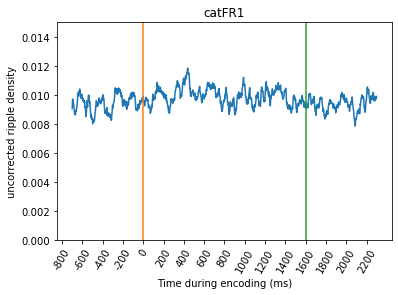

In [69]:
print(np.shape(ripple_array))
plot(np.mean(ripple_array,0))
if selected_period == 'whole_encoding':
    xticks(range(0,20000,2500),range(0,40000,5000))
    plot([0,0],[0,0.015])    
elif selected_period == 'encoding':
    xticks(ticks=range(-350,1501,100),labels=range(-1400,3001,200),rotation=60)
    plot([350,350],[0,0.015])
    plot([1150,1150],[0,0.015])       
ylim(0,0.015)
title(exp)
ylabel('uncorrected ripple density')
xlabel('Time during encoding (ms)');

## to visualize the removal parameters

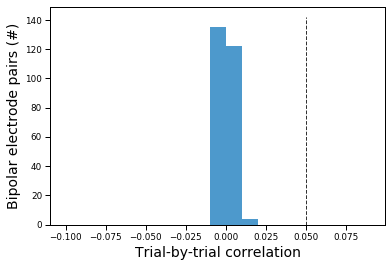

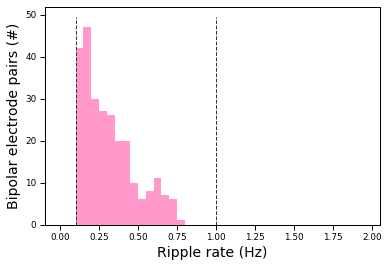

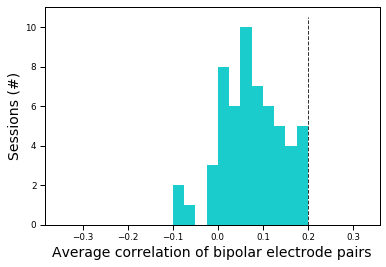

In [43]:
save_figs = 0
# np.array(trial_by_trial_correlation)
# np.array(elec_ripple_rate_array)
# np.array(elec_by_elec_correlation)
set_pubfig()

# trial-by-trial correlation
plt.hist(trial_by_trial_correlation,np.arange(-0.1,0.1,0.01),color = (0.3,0.6,0.8)); 
xlabel('Trial-by-trial correlation'); ylabel('Bipolar electrode pairs (#)'); 
plot([0.05,0.05],[gca().get_ylim()[0],gca().get_ylim()[1]],linewidth=1,linestyle='--',color=(0.2,0.2,0.2),label='_nolegend_')
if save_figs == 1:
    plt.savefig('../figures/control_params/trial-by-trial_correlation.pdf',transparent=True); show()
else:
    show()

# ripple rates
plt.hist(elec_ripple_rate_array,np.arange(0,2,0.05),color = (1,0.6,0.8)); 
xlabel('Ripple rate (Hz)'); ylabel('Bipolar electrode pairs (#)'); 
ylims = [gca().get_ylim()[0],gca().get_ylim()[1]]
plot([0.1,0.1],ylims,linewidth=1,linestyle='--',color=(0.2,0.2,0.2),label='_nolegend_')
plot([1,1],ylims,linewidth=1,linestyle='--',color=(0.2,0.2,0.2),label='_nolegend_')
if save_figs == 1:
    plt.savefig('../figures/control_params/ripple_rates_by_electrode.pdf',transparent=True); show()
else:
    show()
    
plt.hist(elec_by_elec_correlation,np.arange(-0.35,0.35,0.025),color = (0.1,0.8,0.8)); 
xlabel('Average correlation of bipolar electrode pairs'); ylabel('Sessions (#)'); 
plot([0.2,0.2],[gca().get_ylim()[0],gca().get_ylim()[1]],linewidth=1,linestyle='--',color=(0.2,0.2,0.2),label='_nolegend_')
if save_figs == 1:
    plt.savefig('../figures/control_params/sessions_electrode_correlations.pdf',transparent=True)
show();

#     max_ripple_rate = 3 #1.5 # Hz.
#     max_trial_by_trial_correlation = 1 #0.05 # if ripples correlated more than this remove them
#     max_electrode_by_electrode_correlation = 1 #0.2 #???
#     if filter_type == 'hamming':
#         min_ripple_rate = 0 # 0.1 # Hz.
#     else:
#         min_ripple_rate = 0.05 # for methods with lower rates decrease the minimum cutoff

## Get start_array and select subfield if HPC for free recalls

In [6]:
## DO YOU WANT TO SELECT A SUBFIELD or OUTPUT POSITION?? ##  

select_subfield = False   # note: if you already ran this once, have to load again from data
                          # also this is only for HPC. So set to False for ENT and PHC
    
# select for subfield if HPC
if select_subfield == True:
    location_selected = 'ca1' #'dg' # 'ca3' # 'dg' 'ca1' # sub # ['ca1','dg']
        # left # right # left hippocampus # right hippocampus # hippocampus
        # to see number of each: sum(np.array([names.find('sub') for names in HPC_names])>=0)
else:
    location_selected = ''
    

### Use a task condition to select recalls?? ###
### ...will select first one that's not 0    ###
select_ordinal_position = 0              # select only recalls at given output position. 0 means it's off ##DEPRECATED
select_list_position = 0 #[1,2,3] #[12]  # select only recalls at given position from encoding list. 
                                         # 0 means it's off. Must be list
select_less_than_rectime = 0             # select only recalls < this number % 5000
select_greater_than_rectime = 0          # select only recalls ≥ this number % 5000
select_lists_with_recalls = 0 # list(np.arange(3,13)) # [1] so this would select ≥4 recalls. Must be list hence the list(arange...)
                                         # select only recalls that come from lists with number in this list
select_intrusions_next = 0               # select recalls that lead to intrusions
    
if filter_type.find('hamming') != -1:
    desired_sample_rate = 500.
else:
    desired_sample_rate = 1000.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

print('Total electrodes loaded: '+str(len(trial_nums)))
print('from '+str(len(np.unique(sub_sess_names)))+' sessions from '+str(len(np.unique(sub_names)))+' subjects with trial nums:')
print(trial_nums[0:20])
print('Trial sum = '+str(np.sum(trial_nums)))
print(HPC_names[0:20])
print('Number of sub_sess names: '+str(len(sub_sess_names)))


start_array,end_array = getStartEndArrays(ripple_array); print('Got encoding start_array!')
 
# if selected an output position
if select_ordinal_position > 0:
    if np.min(ordinal_position_array) == 0: # only update this once (so don't have to reload data from files)
        ordinal_position_array = np.array(ordinal_position_array)+1 # now 1-indexed
    selected_recalls = ordinal_position_array==select_ordinal_position
elif type(select_list_position) == list:
    selected_recalls = [sp in select_list_position for sp in serialpos_array]
elif select_intrusions_next == 1:
    selected_recalls = np.array(recall_before_intrusion_array)==True
elif select_less_than_rectime > 0:
    selected_recalls = np.array(rectime_array)<select_less_than_rectime
elif select_greater_than_rectime > 0:
    selected_recalls = np.array(rectime_array)>=select_greater_than_rectime
elif type(select_lists_with_recalls) == list:
    selected_recalls = [recall in select_lists_with_recalls for recall in list_recall_num_array]
else:
    selected_recalls = np.ones(len(start_array),dtype=bool)
    
# get locations if selected

if select_subfield == True:
    # create the full vector of location name predictors
    location_names = []
    for s in range(len(HPC_names)):
        new_trials = int(trial_nums[s])
        location_names.extend(np.tile(HPC_names[s],new_trials))  
        
    # now can get mask of trials in this location
    
    #first, if there are two locations to combine, sort that out (DG and CA1 in particular)
    location_mask = np.zeros(len(location_names))
    for s in range(len(location_names)):
        if type(location_selected)==list:
            if location_names[s].find(location_selected[0])>=0 or location_names[s].find(location_selected[1])>=0:
                location_mask[s] = True
        elif type(location_selected)==str:
            if location_names[s].find(location_selected)>=0:
                location_mask[s] = True
else:
    location_mask = np.ones(len(start_array))

# DON'T USE temp_recall_idxs FOR ENCODING
# # gotta translate this to new frame as well from idxs in load step if selected subfield
# if select_subfield == True: 
#     location_mask = location_mask[temp_recall_idxs] 

# combine location and sorted recalls to get new ripple array:
updated_recalls = (location_mask+selected_recalls)==2

# these lists did not have 12 word presentations, so remove them
if exp == 'catFR1':
    updated_recalls[(np.array(session_name_array)=='R1180C-2') & (np.array(list_num_key)==24)] = 0
    updated_recalls[(np.array(session_name_array)=='R1278E-10') & (np.array(list_num_key)==25)] = 0
    
    
# translate these predictors to vector and select recalls
start_array = start_array[updated_recalls]
end_array = end_array[updated_recalls] # used for duration calculations
subject_name_array = np.array(subject_name_array)[updated_recalls]
session_name_array = np.array(session_name_array)[updated_recalls]
electrode_array = np.array(electrode_array)[updated_recalls]
channel_coords_array = np.array(channel_coords_array)[updated_recalls]
# channel_nums_array = np.array(channel_nums_array)[updated_recalls]
category_array = np.array(category_array)[updated_recalls]
# if selected_period in ['surrounding_recall','math','math_retrieval']:
#     list_recall_num_array = list_recall_num_array[updated_recalls] # for subject-level analysis
# rectime_array = np.array(rectime_array)[updated_recalls]
# recall_position_array = np.array(recall_position_array)[updated_recalls]

# specific to encoding
# serialpos_array = np.array(serialpos_array)[updated_recalls] # FIX THIS ONCE RUN AGAIN 2021-09-16
# list_recall_num_array = np.array(list_recall_num_array)[updated_recalls]

# entend all of these into arrays
temp = []
for enc in encoded_word_key_array:
    temp.extend(enc)
encoded_word_key_array = copy(temp)
temp = []
for enc in serialpos_array:
    temp.extend(enc)
serialpos_array = copy(temp)
temp = []

encoded_word_key_array = np.array(encoded_word_key_array)[updated_recalls]
serialpos_array = np.array(serialpos_array)[updated_recalls]
list_num_key = np.array(list_num_key)[updated_recalls]
word_correct_array = word_correct_array[updated_recalls]
recall_position_array = np.array(recall_position_array)[updated_recalls]
semantic_clustering_key = np.array(semantic_clustering_key)[updated_recalls]
recall_position_array = np.array(recall_position_array)[updated_recalls]
    
print('Got start_array with '+str(start_array.shape[0])+' trials!')

sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
print('Number of electrodes: '+str(len(np.unique(sub_elec))))
print('...from '+str(len(np.unique(subject_name_array)))+' patients')
        
# # plot whole retrieval period with FR events superimposed on SWRs
# if selected_period == 'whole_bretrieval':
#     start_array2 = start_array # for whole retrieval period
#     print('Base SWRs/30 s retrieval: '+str(sum(start_array2)/start_array2.shape[0]/(30000/1000)))
#     ## can go straight to "SWRs by time in retrieval period" from here
# else:
#     print('SWRs rate in 4 s around FR: '+str(sum(start_array)/start_array.shape[0]/(4000/1000)))

# # subplots(1,1,figsize=(6,9))
# # plot([0,0],[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # plot(np.ones(2)*(retrieval_whole_time),[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # scatter(np.where(start_array2)[1]*sr_factor+psth_start,np.where(start_array2)[0],s=0.5)
# # scatter(np.where(fr_array)[1],np.where(fr_array)[0],s=0.5,color=[1,0,0]); 
# # plt.xlabel('Retrieval period time (ms)')
# # plt.ylabel('Retrieval period')
# # if save_plot == 1:
# #     plt.savefig('../plots/'+'SWR_FR_'+region_name+'-'+str(session_ct)+'_sessions_in-'+str(sub_num)+'subjects_'+filter_type+'.pdf',transparent=True)
# # plt.show();    

print('# of trials: '+str(np.shape(start_array)[0]))
print('Total # of ripples: '+str(sum(start_array)))
print('Overall ripple rate: '+str(np.round( (1000/sr_factor)*sum(start_array)/np.shape(start_array)[0]/np.shape(start_array)[1],3 ))+' Hz')

Total electrodes loaded: 261
from 72 sessions from 35 subjects with trial nums:
[120. 120. 120. 120. 120. 120. 120. 240. 240. 240. 240. 300. 300. 300.
 300. 300. 300. 300. 300. 300.]
Trial sum = 50098.0
['left sub', 'left ca1', 'left ca1', 'left sub', 'left ca1', 'left dg', 'left ca1', 'left hippocampus', 'left hippocampus', 'left ca2', 'left hippocampus', 'left ca1', 'left dg', 'left dg', 'left ca1', 'left dg', 'left dg', 'right sub', 'right ca1', 'left dg']
Number of sub_sess names: 261
Got encoding start_array!


IndexError: boolean index did not match indexed array along dimension 0; dimension is 50076 but corresponding boolean dimension is 50098

'R1501J'

In [39]:
encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700
ripple_bin_start_end = [300,1300] # range I'm going to look for ripples for regression of serialpos and category predictors

adj_semantic_encoding_array = []
rem_semantic_encoding_array = []
rem_unclustered_encoding_array = []
last_recall_encoding_array = [] # the last word remembered on each list (no transitions)...but make sure it's not an intrusion or repeat too!
sub_name_array0 = []; sess_name_array0 = []
sub_name_array1 = []; sess_name_array1 = []
sub_name_array2 = []; sess_name_array2 = []
sub_name_array3 = []; sess_name_array3 = []

session_names = np.unique(session_name_array)

for sess in session_names:
    sess_list_nums = np.unique(list_num_key[session_name_array==sess])    
        
    for ln in sess_list_nums:
        list_elec_array = np.unique(electrode_array[(session_name_array==sess) & (list_num_key==ln)])
        
        for elec in list_elec_array:
        
            list_ch_idxs = (session_name_array==sess) & (list_num_key==ln) & (electrode_array==elec)
            
            list_ch_encoding_array = start_array[list_ch_idxs]
            list_ch_cats = category_array[list_ch_idxs]
            list_ch_corr = word_correct_array[list_ch_idxs]
            list_ch_semantic_key = semantic_clustering_key[list_ch_idxs]
            list_ch_recall_positions = recall_position_array[list_ch_idxs]
            
            for i_recall_type,recall_type in enumerate(list_ch_semantic_key[0]): # all 12 words have same values for semantic key
                
                recall_position = list_ch_recall_positions[0][i_recall_type]
                if recall_type == 'A': # adjacent semantic
                    # note the -1 since recall positions are on scale of 1-12
                    adj_semantic_encoding_array = superVstack(adj_semantic_encoding_array,list_ch_encoding_array[recall_position-1])
                    sub_name_array0.append(sess[0:6])
                    sess_name_array0.append(sess)
                elif recall_type == 'C': # remote semantic
                    rem_semantic_encoding_array = superVstack(rem_semantic_encoding_array,list_ch_encoding_array[recall_position-1])
                    sub_name_array1.append(sess[0:6])
                    sess_name_array1.append(sess)
                elif ( (recall_type == 'D') & (recall_position>0) ): # remote unclustered
                    rem_unclustered_encoding_array = superVstack(rem_unclustered_encoding_array,list_ch_encoding_array[recall_position-1])
                    sub_name_array2.append(sess[0:6])
                    sess_name_array2.append(sess)                    
                elif ( (recall_type == 'Z') & (recall_position>0) ): # last word of list & was actually a recalled word
                    last_recall_encoding_array = superVstack(last_recall_encoding_array,list_ch_encoding_array[recall_position-1])
                    sub_name_array3.append(sess[0:6])
                    sess_name_array3.append(sess)
            test=1

In [30]:
np.shape(adj_semantic_encoding_array)
sum(adj_semantic_encoding_array,0)
np.shape(rem_semantic_encoding_array)
sum(rem_semantic_encoding_array,0)
len(rem_unclustered_encoding_array)
len(last_recall_encoding_array)

(3454, 1500)

array([41,  5,  4, ...,  5,  5,  2], dtype=uint64)

(3665, 1500)

array([37,  1,  3, ...,  2,  6,  5], dtype=uint64)

3935

2868

In [42]:
test = eval('sub_name_array'+str(0))
np.shape(test)

(3454,)

## SCE (Subsequent Clustering Effect?)

done making binned start_array with shape:
(3665, 26)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


SEs created!
done making binned start_array with shape:
(2868, 26)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_lin

SEs created!


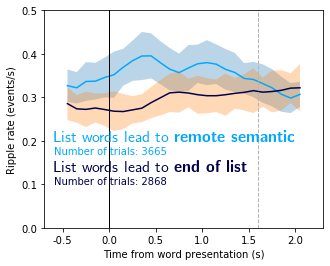

In [44]:
save_plot_data = 0
plot_SE = 1

# get PSTH for two of the types
plot_two = [1,3] 
# 0 is adjacent_semantic, 1 is remote_semantic, 2 is remote unclustered, 3 is end of list

bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?


# for recalled and then forgotten words
for array_num in plot_two:
    if array_num == 0:
        temp_start_array = adj_semantic_encoding_array
        label = 'List words lead to \\textbf{adjacent semantic}'
        plot_color = (0,0.33,1)
    elif array_num == 1:
        temp_start_array = rem_semantic_encoding_array
        label = 'List words lead to \\textbf{remote semantic}'
        plot_color = (0,0.66,1)
    elif array_num == 2:
        temp_start_array = rem_unclustered_encoding_array
        label = 'List words lead to \\textbf{remote unclustered}'
        plot_color = (0,0.3,0)
    elif array_num == 3:
        temp_start_array = last_recall_encoding_array
        label = 'List words lead to \\textbf{end of list}'
        plot_color = (0,0,0.3)
    sub_name_array = eval('sub_name_array'+str(array_num))
    sess_name_array = eval('sess_name_array'+str(array_num))

    if array_num == plot_two[0]:
        # for plot
        subplots(1,1,figsize=(5,4))        
        text(-600,0.2,label,usetex=True,size=16,color=plot_color) 
        text(-600,0.17,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)
    else:
        text(-600,0.13,label,usetex=True,size=16,color=plot_color) 
        text(-600,0.10,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)        
        
    # make a PSTH based on start times of SWRs

    PSTH,bin_centers = fullPSTH(temp_start_array,bin_size,smoothing_triangle,sr,pre_encoding_time)
    # bootstraps error bars by sampling from trials in raster with replacement samples number of
    # times and then taking the standard deviation across those samples
#     boot_samples = bootstrap(temp_start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
#                    bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,pre_encoding_time))
#     boot_SD = np.std(boot_samples,0)

    # get binned start array (trials X bins)
    binned_start_array = binBinaryArray(temp_start_array,bin_size,sr_factor)
    if pad > 0:
        binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
    print('done making binned start_array with shape:')
    print(binned_start_array.shape)

    # note that output is the net ± distance from mean
    if plot_SE == True:
        SE_plot = getMixedEffectSEs(binned_start_array,sub_name_array,sess_name_array)
        print('SEs created!')
    
    # plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    xr = xr[pad:-pad]; 
    
    plot(xr,PSTH[pad:-pad],color=plot_color)
    if plot_SE == True:
        fill_between(xr, PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:], alpha = 0.3)
        
xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
       np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
xlabel('Time from word presentation (s)')
ylabel('Ripple rate (events/s)')
ax = plt.gca()
ylim = 0.5
ax.set_ylim(0,ylim)
ax.set_xlim(pre_encoding_time,encoding_time)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))
    
#     if category == 0:
#         PSTH_recalled = copy(PSTH)
#         SE_recalled = copy(SE_plot)
#     else:
#         PSTH_forgotten = copy (PSTH)
#         SE_forgotten = copy(SE_plot)

# # now that we have the plot with CIs, do stats on key bins. Note here just looking at single bins but comparing across categories
# for test in range(2):
#     if test == 0:
#         first_start = 300
#         first_end = 1300
#     else:
#         first_start = 1700 # same idea but for post-encoding period (ILI)
#         first_end = 2300 
        
#     bin_test_range = range(int( ((first_start-pre_encoding_time)/sr_factor) ),
#                            int( ((first_end-pre_encoding_time)/sr_factor) ))
#     binned_recalled_array = start_array_enc_recalled[:,bin_test_range]
#     binned_forgot_array = start_array_enc_forgot[:,bin_test_range]
    
#     stats_bin = int(first_end-first_start)
#     binned_recalled_array = binBinaryArray(binned_recalled_array,stats_bin,sr_factor) # should be creating vectors for both
#     binned_forgot_array = binBinaryArray(binned_forgot_array,stats_bin,sr_factor)
    
#     bin_model = MEstatsAcrossCategories(binned_recalled_array,binned_forgot_array,
#                                         sub_forgot,sess_forgot,sub_recalled,sess_recalled)
    
#         # plot bands of significance
#     if bin_model.pvalues[1] < 0.05:
#         plot([first_end-stats_bin,first_end],[0.5,0.5],color=(1,0.5,0))
    
#     if test == 0:
#         bin_model1 = copy(bin_model)
#         binned_recalled_array1 = copy(binned_recalled_array)
#         binned_forgot_array1 = copy(binned_forgot_array)
#     else:
#         bin_model2 = copy(bin_model)
#         binned_recalled_array2 = copy(binned_recalled_array)
#         binned_forgot_array2 = copy(binned_forgot_array)
# num_trials = len(master_key) 


# # get directories for if you save (don't put this in save_plot_data below since want p-values printed at bottom close to figures)
# soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
# path_name = '/home1/john/SWR/figures/'+subfolder

# fn = os.path.join(path_name,
#     'SWR_SCE_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
#                   '_'+filter_type+'_'+sub_selection+'.p') # -GT_5000.p' # -LT_5000.p' #'-intrusions.p'
# print(fn)
# print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
# print('Test 2 p-value: '+str(bin_model2.pvalues[1]))
# print(str(num_trials)+' trials')    
        
if save_plot_data == 1:
    # get strings for path name for save and loading cluster data
            
    if os.path.isdir(path_name) == False:
        os.mkdir(path_name)
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    with open(fn,'wb') as f:
        pickle.dump({'bin_centers':bin_centers,'PSTH_recalled':PSTH_recalled,'PSTH_forgotten':PSTH_forgotten,
                    'SE_recalled':SE_recalled,'SE_forgotten':SE_forgotten,'bin_model1':bin_model1,'bin_model2':bin_model2,
                    'binned_recalled_array1':binned_recalled_array1,'binned_forgot_array1':binned_forgot_array1,
                    'binned_recalled_array2':binned_recalled_array2,'binned_forgot_array2':binned_forgot_array2,
                    'subject_name_array':subject_name_array,'session_name_array':session_name_array,
                    'electrode_array':electrode_array,'channel_coords_array':channel_coords_array,
                    'master_key':master_key}, f) 
        # master_key is indicator for subsequently remembered and forgotten. Can get num_trials from it too
a=1;

## go down to the list level and pick out which words are 1st, 2nd, 3rd, and 4th repeats of each *category*

In [64]:
%autoreload

select_category_repeat = 0 # 1, 2, 3, 0 # 0 means use all categories. 1:3 mean select only 1st, 2nd, 3rd usage of category

encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700
ripple_bin_start_end = [300,1300] # range I'm going to look for ripples for regression of serialpos and category predictors

session_names = np.unique(session_name_array)
r1 = [] # 4 ripple arrays
r2 = []
r3 = []
r4 = []
r1r4_subject_name_array = []
r1r4_session_name_array = []
r6 = [] # one idea to account for drop in ripples in each encoding period: compare 6th word (always a 2nd of 1st cat) to 7th (always 3rd of a cat)
r7 = [] 
r6_sub_array = []; r7_sub_array = []
r6_sess_array = []; r7_sess_array = []

# accumulated arrays for regression
category_presentation = []
word_presentation_serialpos = []
word_presentation_ripples = []
regression_subject_name_array = []
regression_session_name_array = []

# session_names = ['R1239E-1']

for sess in session_names:
    sess_list_nums = np.unique(list_num_key[session_name_array==sess])    
    
    # get indicator of whether category is 1st, 2nd, or 3rd time used in a given session 
    category_repeat_array = getCategoryRepeatIndicator(sess,electrode_array,session_name_array,category_array)
    
    num_elecs_in_session = len(np.unique(electrode_array[(session_name_array==sess)]))
    if num_elecs_in_session > 1:           
            category_repeat_array = np.tile(category_repeat_array,num_elecs_in_session)
    session_list_num_key = list_num_key[session_name_array==sess] # need this so can get the right category_repeats by list_num below
        
    for ln in sess_list_nums:
        # for each list in each session, figure out which encoding events are 1st, 2nd, 3rd, and 4th from each category
        # (could really do this at the session-level but just in case a list was repeated somehow do it at the list-level)
        list_cats = category_array[((session_name_array==sess) & (list_num_key==ln))] # note that this is this list for *every* electrode
        list_start_array = start_array[((session_name_array==sess) & (list_num_key==ln))]
        list_category_repeat_array = category_repeat_array[session_list_num_key==ln] # indicator of category repeats across lists (for current ln)
        
        if ( (len(list_cats) % 12 == 0) and (len(np.unique(list_cats)) == 3) ): # make sure all the words were presented for this session and there are 3 categories
            
            # get these arrays for SE_plot hierarchical model
            quarter_session_trials = int(sum((session_name_array==sess) & (list_num_key==ln))/4)
            r1r4_subject_name_array.extend(subject_name_array[((session_name_array==sess) & (list_num_key==ln))][0:quarter_session_trials])
            r1r4_session_name_array.extend(session_name_array[((session_name_array==sess) & (list_num_key==ln))][0:quarter_session_trials])
            
            # serialpositions for regression of list number v. category number
            word_presentation_serialpos.extend(serialpos_array[((session_name_array==sess) & (list_num_key==ln))])
            regression_subject_name_array.extend(subject_name_array[((session_name_array==sess) & (list_num_key==ln))])
            regression_session_name_array.extend(session_name_array[((session_name_array==sess) & (list_num_key==ln))])            
         
            cat_counter = [0,0,0]
            unique_cats = np.unique(list_cats)
                        
            # for every trial use the category name to append to the right ripple array    
            for i_word_cat,word_cat in enumerate(list_cats): 
                cat_idx = int(findInd(unique_cats == word_cat)) # get index for which of 3 categories this word is from
                current_count = cat_counter[cat_idx] # get current count for how many times this word has been used   
                

                # keep track of information for regression of list number v. category number
                category_presentation.append(current_count % 4) # keep track of category presentation number (1st-4th time category used)
                # get ripples in 300:1300 bin for ME model
                word_presentation_ripples.append( sum(list_start_array[i_word_cat,int((abs(pre_encoding_time)+ripple_bin_start_end[0])/sr_factor):
                                                                                 int((abs(pre_encoding_time)+ripple_bin_start_end[1])/sr_factor)]) )
                
                
                # if selecting for how many times this category is repeated (select_category_repeat==0 means keep all)
                if ( (list_category_repeat_array[i_word_cat] == select_category_repeat) | (select_category_repeat==0) ):
                
                    if current_count % 4 == 0:
                        r1 = superVstack(r1,list_start_array[i_word_cat])
                    elif current_count % 4 == 1:
                        r2 = superVstack(r2,list_start_array[i_word_cat])                    
                    elif current_count % 4 == 2:
                        r3 = superVstack(r3,list_start_array[i_word_cat])  
                    elif current_count % 4 == 3:
                        r4 = superVstack(r4,list_start_array[i_word_cat])                      
                
                cat_counter[int(findInd(unique_cats == word_cat))] +=1 # increment counter for this category
                
                # separately, just record the 6th and 7th words in each list only
                if i_word_cat % 11 == 5:
                    r6 = superVstack(r6,list_start_array[i_word_cat])
                    r6_sub_array.append(r1r4_subject_name_array[-1])
                    r6_sess_array.append(r1r4_session_name_array[-1])                    
                if i_word_cat % 11 == 6:
                    r7 = superVstack(r7,list_start_array[i_word_cat])
                    r7_sub_array.append(r1r4_subject_name_array[-1])
                    r7_sess_array.append(r1r4_session_name_array[-1]) 
        else:
            print(sess)
            print(ln)
                    
# sanity check (should not matter since the if statement above should take care of everything)                
if ( (len(r1)!=len(r4)) or (len(r1)!=len(r1r4_session_name_array)) ):
    if select_category_repeat == 0:
        print('There is something wrong, we do not have the same number of trials in ripple array or session_name_array')

## get PSTH for all 4 encoding categories: Novel, 1st, 2nd, and 3rd repeat of category

done making binned start_array with shape:
(12519, 26)
SEs created!
done making binned start_array with shape:
(12519, 26)
done making binned start_array with shape:
(12519, 26)
done making binned start_array with shape:
(12519, 26)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


SEs created!


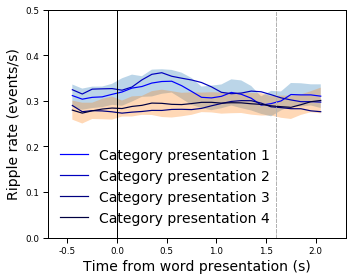

In [75]:
%autoreload

# Then bin it for the CIs and plot each
# then do ME stats on seleted bins and add significance bars if p<0.05

plot_SEs = 1

bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?
sr_factor = 2

# subject_name_array and session_name_array are the same for all 4 

# for 4 presentations of same category
for category in range(4):
    if category == 0:
        temp_start_array = r1
        
        # for plot
        subplots(1,1,figsize=(5,4))        
        plot_color = (0,0,1) #(1,0,0)
        label = 'Category presentation 1'
#         text(500,0.21,label,usetex=True,size=16,color=plot_color)
#         text(500,0.18,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)

    elif category == 1:       
        label = 'Category presentation 2'
        temp_start_array = r2        
        plot_color = (0,0,0.75) #(0.75,0,0)
    elif category == 2:       
        label = 'Category presentation 3'
        temp_start_array = r3        
        plot_color = (0,0,0.5) # (0.5,0,0)
    elif category == 3:       
        label = 'Category presentation 4'
        temp_start_array = r4        
        plot_color = (0,0,0.25) #(0.25,0,0)
        
    # make a PSTH based on start times of SWRs

    PSTH,bin_centers = fullPSTH(temp_start_array,bin_size,smoothing_triangle,sr,pre_encoding_time)
    # bootstraps error bars by sampling from trials in raster with replacement samples number of
    # times and then taking the standard deviation across those samples
#     boot_samples = bootstrap(temp_start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
#                    bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,pre_encoding_time))
#     boot_SD = np.std(boot_samples,0)

    # get binned start array (trials X bins)
    binned_start_array = binBinaryArray(temp_start_array,bin_size,sr_factor)
    if pad > 0:
        binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
    print('done making binned start_array with shape:')
    print(binned_start_array.shape)

    # note that output is the net ± distance from mean

    if (plot_SEs == 1) & (category in [0,3]):
        SE_plot = getMixedEffectSEs(binned_start_array,r1r4_subject_name_array,r1r4_session_name_array)
        print('SEs created!')
    
    # plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    xr = xr[pad:-pad]; 
    
    plot(xr,PSTH[pad:-pad],color=plot_color,label = label)
    
    if (plot_SEs == 1) & (category in [0,3]):
        fill_between(xr, PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:], alpha = 0.3)
    xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
           np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
    xlabel('Time from word presentation (s)')
    ylabel('Ripple rate (events/s)')
    tight_layout()
    ax = plt.gca()
    ylim = 0.5
    ax.set_ylim(0,ylim)
    ax.set_xlim(pre_encoding_time,encoding_time)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
    plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))
    
leg = ax.legend(frameon=False,prop={'size': 14})
a=1;

# Daniel and David are suggesting complementary analyses of remembering one category dependent on ripples during presentation of the same category at different times

In [173]:
# first let's get the set of trials where a ripple happened on the second category presentation 
# (the 3rd and 4th words from a category)

cat_3_12_same = [] # same category 1 & 2 as 3 with a ripple (2 per list)
cat_3_12_diff = [] # diff category 1 & 2 as 3 with a ripple (4 per list)
cat_2_34_same = [] # same category 3 & 4 as 2 with a ripple (2 per list)
cat_2_34_diff = [] # diff category 3 & 4 as 2 with a ripple (2 per list)
cat_1_234_same = [] 
cat_1_234_diff = [] 
cat_2_1_same = [] 
cat_2_1_diff = [] 
cat_12_34ripple_34 = []
cat_12_34noripple_34 = []

for sess in session_names:
    sess_list_nums = np.unique(list_num_key[session_name_array==sess])    
        
    for ln in sess_list_nums:
        list_elec_array = np.unique(electrode_array[(session_name_array==sess) & (list_num_key==ln)])
        
        for elec in list_elec_array:
        
            list_ch_idxs = (session_name_array==sess) & (list_num_key==ln) & (electrode_array==elec)
            
            list_ch_presentations = np.array(category_presentation)[list_ch_idxs] # note this is 1 to 4
            list_ch_encoding_array = start_array[list_ch_idxs,int((abs(pre_encoding_time)+ripple_bin_start_end[0])/sr_factor): 
                                                   int((abs(pre_encoding_time)+ripple_bin_start_end[1])/sr_factor)]
            list_ch_cats = category_array[list_ch_idxs]
            list_ch_corr = word_correct_array[list_ch_idxs]

            # First, let's check category_presentation = 3 for ripples and see if it predicts better memory 
            # for the same category for category_presentation 1 or 2
            
            for cat_3_idx in findInd(list_ch_presentations==2): # go through each of 3 categories (0-indexed)
                if sum(list_ch_encoding_array[cat_3_idx,:])>0: # if there's a ripple...
                    # ...check accuracy of presentation 1 and 2 from this same cat v. the other 4 words from the other 2 cats
                    selected_cat = list_ch_cats[cat_3_idx]
                    cat_3_12_same.extend(list_ch_corr[(list_ch_cats==selected_cat) & ( (list_ch_presentations==0)|(list_ch_presentations==1) )])
                    cat_3_12_diff.extend(list_ch_corr[(list_ch_cats!=selected_cat) & ( (list_ch_presentations==0)|(list_ch_presentations==1) )])

                    
            # same idea, but see if ripple during 2nd category presentation leads to better memory for 3&4
            for cat_2_idx in findInd(list_ch_presentations==1): # (0-indexed)
                if sum(list_ch_encoding_array[cat_2_idx,:])>0: # if there's a ripple...
                    # ...check accuracy of presentation 3 and 4 from this same cat v. the other 4 words from the other 2 cats
                    selected_cat = list_ch_cats[cat_2_idx]
                    cat_2_34_same.extend(list_ch_corr[(list_ch_cats==selected_cat) & ( (list_ch_presentations==2)|(list_ch_presentations==3) )])
                    cat_2_34_diff.extend(list_ch_corr[(list_ch_cats!=selected_cat) & ( (list_ch_presentations==2)|(list_ch_presentations==3) )])

            # same idea, but see if ripple during 1st category presentation leads to better memory for 2-4
            for cat_1_idx in findInd(list_ch_presentations==0): # (0-indexed)
                if sum(list_ch_encoding_array[cat_1_idx,:])>0: # if there's a ripple...
                    # ...check accuracy of presentations 2-4 from this same cat v. the other 4 words from the other 2 cats
                    selected_cat = list_ch_cats[cat_1_idx]
                    cat_1_234_same.extend(list_ch_corr[(list_ch_cats==selected_cat) & ( (list_ch_presentations==1)|(list_ch_presentations==2)|(list_ch_presentations==3) )])
                    cat_1_234_diff.extend(list_ch_corr[(list_ch_cats!=selected_cat) & ( (list_ch_presentations==1)|(list_ch_presentations==2)|(list_ch_presentations==3) )])
                    
            # same idea, but see if ripple during 2nd category presentation leads to better memory for 1st
            for cat_2_idx in findInd(list_ch_presentations==1): # (0-indexed)
                if sum(list_ch_encoding_array[cat_2_idx,:])>0: # if there's a ripple...
                    # ...check accuracy of presentations 2-4 from this same cat v. the other 4 words from the other 2 cats
                    selected_cat = list_ch_cats[cat_2_idx]
                    cat_2_1_same.extend(list_ch_corr[ (list_ch_cats==selected_cat) & (list_ch_presentations==0) ])
                    cat_2_1_diff.extend(list_ch_corr[ (list_ch_cats!=selected_cat) & (list_ch_presentations==0) ])    
                    
            # David's idea was actually a little different. He expects if there are ripples on 3rd/4th trial...
            # there will be greater p(recall 3/4 | recall 1/2) (given a 1/2 recall already happened)
            for cat_12_idx in findInd( (list_ch_presentations==0)|(list_ch_presentations==1) ): # (0-indexed)
                if list_ch_corr[cat_12_idx] == 1: # if recalled 1/2...
                    same_cat_idxs = findInd(list_ch_cats==list_ch_cats[cat_12_idx])[2:] # grab idxs of 3rd and 4th from this same category
                    if sum(list_ch_encoding_array[same_cat_idxs])>0: # if ripple in either 3rd or 4th trial
                        cat_12_34ripple_34.extend(list_ch_corr[same_cat_idxs])
                    else:
                        cat_12_34noripple_34.extend(list_ch_corr[same_cat_idxs])
a=1;                

In [177]:
np.mean(cat_12_34ripple_34)
np.mean(cat_12_34noripple_34)
len(cat_12_34ripple_34)
len(cat_12_34noripple_34)
stats.ttest_ind(cat_12_34ripple_34,cat_12_34noripple_34)

0.42647477913935594

0.39597380080909267

7018

10382

Ttest_indResult(statistic=4.017225518045479, pvalue=5.913486357819762e-05)

In [171]:
mean(cat_2_1_same)
mean(cat_2_1_diff)
len(serialpos_array)
serialpos_array[:16]
len(list_recall_num_array)
list_ch_corr
list_ch_cats
same_cat_idxs = findInd(list_ch_cats==list_ch_cats[0])[2:]
same_cat_idxs
list_ch_corr[same_cat_idxs]

0.40805884234090184

0.42452830188679247

50076

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4])

0

array([1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.])

array(['Appliances', 'Appliances', 'BodyParts', 'BodyParts', 'Beverages',
       'Beverages', 'Appliances', 'Appliances', 'BodyParts', 'BodyParts',
       'Beverages', 'Beverages'], dtype='<U14')

array([6, 7])

array([0., 0.])

Ttest_indResult(statistic=1.4448209880536076, pvalue=0.14852487618365648)


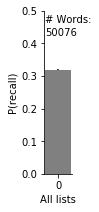

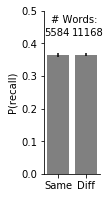

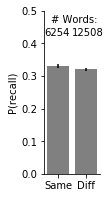

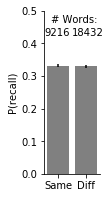

In [151]:
# plot each of these

figSub,axSub = plt.subplots(1,1, figsize=(0.5,3))
axSub.bar( 0, np.mean(word_correct_array), 
              yerr = seFromProp(sum(word_correct_array),len(word_correct_array)),color = (0.5,0.5,0.5))
yticks(np.arange(0,0.501,0.1))
xticks(np.arange(0,1,1))
ylim(0,0.5)
ylabel('P(recall)')
xlabel('All lists')
axSub.spines['top'].set_visible(False)
axSub.spines['right'].set_visible(False)
text(-0.4,0.465,'# Words:')
text(-0.4,0.425,len(word_correct_array))


figSub,axSub = plt.subplots(1,1, figsize=(1,3))
axSub.bar( [0,1], [np.mean(cat_3_12_same),np.mean(cat_3_12_diff)], 
              yerr = [seFromProp(sum(cat_3_12_same),len(cat_3_12_same)),seFromProp(sum(cat_3_12_diff),len(cat_3_12_diff))],
                      color = (0.5,0.5,0.5))
yticks(np.arange(0,0.501,0.1))
xticks(np.arange(0,1.01,1))
axSub.set_xticklabels(['Same','Diff'])
ylim(0,0.5)
ylabel('P(recall)')
axSub.spines['top'].set_visible(False)
axSub.spines['right'].set_visible(False)
text(-0.24,0.465,'# Words:')
text(-0.5,0.425,len(cat_3_12_same))
text(0.5,0.425,len(cat_3_12_diff))


figSub,axSub = plt.subplots(1,1, figsize=(1,3))
axSub.bar( [0,1], [np.mean(cat_2_34_same),np.mean(cat_2_34_diff)], 
              yerr = [seFromProp(sum(cat_2_34_same),len(cat_2_34_same)),seFromProp(sum(cat_3_12_diff),len(cat_3_12_diff))],
                      color = (0.5,0.5,0.5))
yticks(np.arange(0,0.501,0.1))
xticks(np.arange(0,1.01,1))
axSub.set_xticklabels(['Same','Diff'])
ylim(0,0.5)
ylabel('P(recall)')
axSub.spines['top'].set_visible(False)
axSub.spines['right'].set_visible(False)
text(-0.24,0.465,'# Words:')
text(-0.5,0.425,len(cat_2_34_same))
text(0.5,0.425,len(cat_2_34_diff))
print(stats.ttest_ind(cat_2_34_same,cat_2_34_diff))


figSub,axSub = plt.subplots(1,1, figsize=(1,3))
axSub.bar( [0,1], [np.mean(cat_1_234_same),np.mean(cat_1_234_diff)], 
              yerr = [seFromProp(sum(cat_1_234_same),len(cat_1_234_same)),seFromProp(sum(cat_1_234_diff),len(cat_1_234_diff))],
                      color = (0.5,0.5,0.5))
yticks(np.arange(0,0.501,0.1))
xticks(np.arange(0,1.01,1))
axSub.set_xticklabels(['Same','Diff'])
ylim(0,0.5)
ylabel('P(recall)')
axSub.spines['top'].set_visible(False)
axSub.spines['right'].set_visible(False)
text(-0.24,0.465,'# Words:')
text(-0.5,0.425,len(cat_1_234_same))
text(0.5,0.425,len(cat_1_234_diff));


In [ ]:
# David's idea is more like this:
# If you see ripples on 3rd/4th trial, he expects greater recall on 3&4 v. 1/2

## just for 6th v. 7th presented words, to see if Category Presentation 1-2 has more ripples or it's just a decrease over encoding

done making binned start_array with shape:
(4330, 26)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_lin

SEs created!
done making binned start_array with shape:
(4268, 26)


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_lin

SEs created!


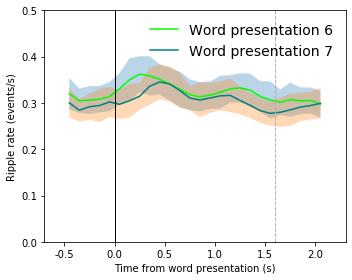

In [79]:
%autoreload

# Then bin it for the CIs and plot each
# then do ME stats on seleted bins and add significance bars if p<0.05

plot_SEs = 1

encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700

bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?
sr_factor = 2

# subject_name_array and session_name_array are the same for all 4 

# for recalled and then forgotten words
for category in range(2):
    if category == 0:
        temp_start_array = r6
        cat_subject_name_array = r6_sub_array
        cat_session_name_array = r6_sess_array
        
        # for plot
        subplots(1,1,figsize=(5,4))        
        plot_color = (0,1,0) #(1,0,0)
        label = 'Word presentation 6'
#         text(500,0.21,label,usetex=True,size=16,color=plot_color)
#         text(500,0.18,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)

    elif category == 1:       
        temp_start_array = r7
        cat_subject_name_array = r7_sub_array
        cat_session_name_array = r7_sess_array
        
        plot_color = (0,0.5,0.5) #(0.75,0,0)
        label = 'Word presentation 7'
        
    # make a PSTH based on start times of SWRs

    PSTH,bin_centers = fullPSTH(temp_start_array,bin_size,smoothing_triangle,sr,pre_encoding_time)
    # bootstraps error bars by sampling from trials in raster with replacement samples number of
    # times and then taking the standard deviation across those samples
#     boot_samples = bootstrap(temp_start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
#                    bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,pre_encoding_time))
#     boot_SD = np.std(boot_samples,0)

    # get binned start array (trials X bins)
    binned_start_array = binBinaryArray(temp_start_array,bin_size,sr_factor)
    if pad > 0:
        binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
    print('done making binned start_array with shape:')
    print(binned_start_array.shape)

    # note that output is the net ± distance from mean
    if plot_SEs == 1:
        SE_plot = getMixedEffectSEs(binned_start_array,cat_subject_name_array,cat_session_name_array)
        print('SEs created!')
    
    # plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    xr = xr[pad:-pad]; 
    
    plot(xr,PSTH[pad:-pad],color=plot_color,label = label)
    if plot_SEs == 1:
        fill_between(xr, PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:], alpha = 0.3)
    xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
           np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
    xlabel('Time from word presentation (s)')
    ylabel('Ripple rate (events/s)')
    tight_layout()
    ax = plt.gca()
    ylim = 0.5
    ax.set_ylim(0,ylim)
    ax.set_xlim(pre_encoding_time,encoding_time)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
    plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))
    
leg = ax.legend(frameon=False,prop={'size': 14})
a=1;

## Same idea, but do regression to test if list presentation number accounts for higher ripples for early categories

In [176]:
np.unique(word_presentation_serialpos)

# put serialpositions into quartiles
quartile_serialpos = np.array(copy(word_presentation_serialpos))
for num in np.arange(2,4):
    mask = (word_presentation_serialpos == num)
    quartile_serialpos[mask] = 1
for num in np.arange(4,7):
    mask = (word_presentation_serialpos == num)
    quartile_serialpos[mask] = 2
for num in np.arange(7,10):
    mask = (word_presentation_serialpos == num)
    quartile_serialpos[mask] = 3    
for num in np.arange(10,13):
    mask = (word_presentation_serialpos == num)
    quartile_serialpos[mask] = 4 
np.unique(quartile_serialpos)

# put serialpositions into terciles
tercile_serialpos = np.array(copy(word_presentation_serialpos))
for num in np.arange(2,5):
    mask = (word_presentation_serialpos == num)
    tercile_serialpos[mask] = 1
for num in np.arange(5,9):
    mask = (word_presentation_serialpos == num)
    tercile_serialpos[mask] = 2
for num in np.arange(9,13):
    mask = (word_presentation_serialpos == num)
    tercile_serialpos[mask] = 3   
np.unique(tercile_serialpos)

# split 4 category_presentations into 2 categories
split_category_presentation = np.array(copy(category_presentation))
for num in np.arange(0,2):
    mask = (category_presentation == num)
    split_category_presentation[mask] = 0
for num in np.arange(2,4):
    mask = (category_presentation == num)
    split_category_presentation[mask] = 1 
np.unique(split_category_presentation)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

array([1, 2, 3, 4])

array([1, 2, 3])

array([0, 1])

In [179]:
quartile_serialpos[0:50]
tercile_serialpos[0:50]
np.array(category_presentation[0:50])
split_category_presentation[0:50]

array([1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4,
       4, 4, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1, 1, 1, 2, 2, 2, 3, 3,
       3, 4, 4, 4, 1, 1])

array([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3,
       3, 3, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 1, 1, 1, 1, 2, 2, 2, 2,
       3, 3, 3, 3, 1, 1])

array([0, 1, 0, 1, 0, 1, 2, 3, 2, 3, 2, 3, 0, 1, 0, 1, 0, 1, 2, 3, 2, 3,
       2, 3, 0, 1, 0, 1, 0, 1, 2, 3, 2, 3, 2, 3, 0, 1, 0, 1, 0, 1, 2, 3,
       2, 3, 2, 3, 0, 1])

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0])

In [185]:
import statsmodels.formula.api as smf

_,counts = np.unique(category_presentation,return_counts=True)
print(counts)

category_df = pd.DataFrame(data={'serialpos':word_presentation_serialpos, #tercile_serialpos #word_presentation_serialpos
                                 'categories':split_category_presentation, #split_category_presentation,#category_presentation
                                 'ripple_rates':word_presentation_ripples,
                                 'subject':regression_subject_name_array,'session':regression_session_name_array})

vc = {'session':'0+session'}
get_bin_CI_model = smf.mixedlm("ripple_rates ~ C(serialpos)+C(categories)", category_df, groups="subject", vc_formula=vc)
bin_model = get_bin_CI_model.fit(reml=True, method='nm',maxiter=5000)
bin_model.summary()

[15543 15543 15543 15543]


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                  MixedLM     Dependent Variable:     ripple_rates
No. Observations:       62172       Method:                 REML        
No. Groups:             71          Scale:                  0.4714      
Min. group size:        144         Likelihood:             -65068.1796 
Max. group size:        5040        Converged:              Yes         
Mean group size:        875.7                                           
------------------------------------------------------------------------
                   Coef.   Std.Err.    z    P>|z|    [0.025     0.975]  
------------------------------------------------------------------------
Intercept           0.448      0.016 27.372 0.000       0.416      0.480
C(serialpos)[T.2]  -0.058      0.013 -4.307 0.000      -0.085     -0.032
C(serialpos)[T.3]  -0.049      0.013 -3.634 0.000      -0.075     -0.023
C(serialpos)[T.4]  -0.056      0.013 -4.178 0.000      -0.083     -0.030
C(serialpos)[T.5]  -0.070      0.013 -5.222 0.000      -0.097     -0.044
C(serialpos)[T.6]  -0.060      0.013 -4.435 0.000      -0.086     -0.033
C(serialpos)[T.7]  -0.163 184868.511 -0.000 1.000 -362335.787 362335.460
C(serialpos)[T.8]  -0.170 184868.511 -0.000 1.000 -362335.794 362335.453
C(serialpos)[T.9]  -0.190 184868.511 -0.000 1.000 -362335.814 362335.433
C(serialpos)[T.10] -0.188 184868.511 -0.000 1.000 -362335.811 362335.436
C(serialpos)[T.11] -0.168 184868.511 -0.000 1.000 -362335.792 362335.455
C(serialpos)[T.12] -0.157 184868.511 -0.000 1.000 -362335.780 362335.467
C(categories)[T.1]  0.063 184868.511  0.000 1.000 -362335.561 362335.686
session Var         0.023      0.004                                    
========================================================================

"""

## For whole_encoding analysis, for each patient find high and low ripple lists

Length of start_array: 32.2


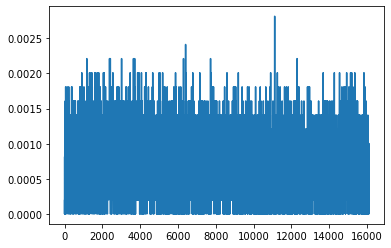

In [31]:
def getHighLowRecallFromRipples(ripples_per_list,sub_list_recall_num_array):
    
    # take list of ripples per trial and output list of correct recall number for high and low ripple lists
    median_ripples = np.median(ripples_per_list)
    high_ripple_idxs = findInd(ripples_per_list > median_ripples)
    low_ripple_idxs = findInd(ripples_per_list <= median_ripples)        
    high_ripple = np.mean(np.array(sub_list_recall_num_array)[np.array(high_ripple_idxs)]) # recalls/list for sub's high ripple lists
    low_ripple = np.mean(np.array(sub_list_recall_num_array)[np.array(low_ripple_idxs)]) # same for low ripple lists
    
    return high_ripple,low_ripple

# kept encoding period long enough for 12*(1.6)+11*(1.0)=30.2 s

min_lists = 20

offset = 100 
presentation_time = 1600
offset_sr = offset/sr_factor # offset of when to look at hippocampal data (in samples). E.g. want to look at word presentation from 100:1700 ms.
presentation_sr = presentation_time/sr_factor

full_encoding_start_array = start_array[:,1000:] # remove 2 sec I added before alignment to first word
print('Length of start_array: '+str(np.round(np.shape(full_encoding_start_array)[1]/1000*2,2)))

sub_recalls_per_list = []

high_ripple_correct = []
low_ripple_correct = []
word_high_ripple_correct = []
word_low_ripple_correct = []
ISI_high_ripple_correct = []
ISI_low_ripple_correct = []

total_ISI_times = []

for sub in np.unique(subject_name_array):
    sub_idxs = [sub in s for s in subject_name_array]
    if sum(sub_idxs) >= min_lists:
        sub_start_array = full_encoding_start_array[sub_idxs]
        sub_subject_name_array = subject_name_array[sub_idxs]
        sub_session_name_array = session_name_array[sub_idxs]
        sub_list_recall_num_array = list_recall_num_array[sub_idxs]
        sub_encoded_word_times = encoded_word_key_array[sub_idxs]
        
        sub_recalls_per_list.append(np.mean(sub_list_recall_num_array)) # record overall recalls/list for sub       

        # this gets you mean values across entirety of retrieval period        
        # 0.875 is average of 0.75-1.0 s and there are 11 ISIs, so this grabs 2.0:30.825 s (first 2 seconds were added for plots)
        ripples_per_list = np.sum(sub_start_array[:,:int(1000+(1600*12/sr_factor)+(875*11/sr_factor))],1)
        
        high_ripple,low_ripple = getHighLowRecallFromRipples(ripples_per_list,sub_list_recall_num_array)
        high_ripple_correct.append(high_ripple)
        low_ripple_correct.append(low_ripple)
        
        # now want to split up word presentation and ISI periods by ripple rate
        
        word_ripples_per_list = []
        ISI_ripples_per_list = []
        
        for trial_num in range(len(sub_start_array)):
            word_ripple_list = []; 
            ISI_ripple_list = []; 
            ISI_times = [] # accumulating these as a check
            for i_word,word_time in enumerate(sub_encoded_word_times[trial_num]):
                # note that I already removed the 2 sec initial buffer at top
                word_ripple_list.append(sum(sub_start_array[trial_num, int(word_time/sr_factor+offset_sr): 
                                                            int(word_time/sr_factor+presentation_sr+offset_sr)]))
#                 word_times.append( (word_time/sr_factor+presentation_sr+offset_sr) - (word_time/sr_factor+offset_sr) ) # these are always 1600 by definition
                if i_word<len(sub_encoded_word_times[trial_num])-1: # last word doesn't have an ISI afterwards
                    ISI_ripple_list.append(sum(sub_start_array[trial_num, int(word_time/sr_factor+presentation_sr+offset_sr):
                                                               int(sub_encoded_word_times[trial_num][i_word+1]/sr_factor+offset_sr)]))
                    ISI_times.append( (sub_encoded_word_times[trial_num][i_word+1]/sr_factor+offset_sr) - (word_time/sr_factor+presentation_sr+offset_sr) )
            # now you have number of ripples in this trial for the 12 words and 11 ISIs
            word_ripples_per_list.append(sum(word_ripple_list))
            ISI_ripples_per_list.append(sum(ISI_ripple_list))
            total_ISI_times.extend(ISI_times) # ISI times seem to be more like 900 ms than 875 ms...likely some lag
            
        # now have ripple rates for each trial for both words and ISIs
        high_ripple,low_ripple = getHighLowRecallFromRipples(word_ripples_per_list,sub_list_recall_num_array)
        word_high_ripple_correct.append(high_ripple)
        word_low_ripple_correct.append(low_ripple)        
        high_ripple,low_ripple = getHighLowRecallFromRipples(ISI_ripples_per_list,sub_list_recall_num_array)
        ISI_high_ripple_correct.append(high_ripple)
        ISI_low_ripple_correct.append(low_ripple)           
        
        a=1
plot(np.mean(full_encoding_start_array,0))

1-sample t-tests:
Whole retrieval: p=0.176, t=-1.37
Word presentations: p=0.063, t=-1.91
ISI: p=0.163, t=-1.42


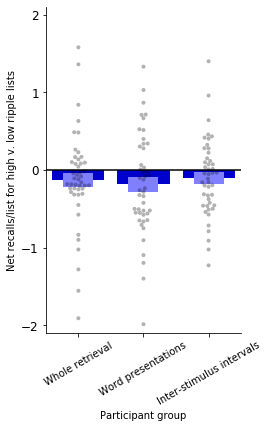

In [36]:
## high v. low recall patients

if location_selected == 'dg':
    min_rate = 0.1
    plot_color = [(0.8,0,0)]
    lmplot_color = (0.8,0,0,0)
    errorbar_color = (1,0.5,0.5)
    line_color = 'darkred'
elif region_name == 'ENT':
    min_rate = 0.0 # for ENT and PHC I don't do further stats so just set to 0 to show all the datapoints in the swarm
    plot_color = [(0.5,0.5,0)]
    lmplot_color = (0,0,0,0)
    errorbar_color = (0.8,0.8,0)
    line_color = 'black'
elif region_name == 'PHC':
    min_rate = 0.0
    plot_color = [(0,0.5,0.5)]
    lmplot_color = (0,0,0,0)
    errorbar_color = (0,0.8,0.8)
    line_color = 'black' 
elif location_selected == 'ca1' or location_selected == '':
    min_rate = 0.1 # for CA1 and DG I require a FR minimum for the two bins being compared since I do further stats on them
    plot_color = [(0,0,0.8)]
    lmplot_color = (0,0,0.8,0)
    errorbar_color = (0.5,0.5,1)
    line_color = 'darkblue'

high_low_diffs = np.concatenate(( np.array(high_ripple_correct)-np.array(low_ripple_correct),
                                  np.array(word_high_ripple_correct)-np.array(word_low_ripple_correct) ))
high_low_diffs = np.concatenate(( high_low_diffs, np.array(ISI_high_ripple_correct)-np.array(ISI_low_ripple_correct) ))
    
plot_df = pd.DataFrame({'high_low_diffs':high_low_diffs,
                        'idxs':np.concatenate(( np.zeros(len(high_ripple_correct)),np.ones(len(word_high_ripple_correct)), 
                                                2*np.ones(len(ISI_high_ripple_correct)) ))
                        })

mean_correct = [np.mean( np.array(high_ripple_correct)-np.array(low_ripple_correct) ),
                np.mean( np.array(word_high_ripple_correct)-np.array(word_low_ripple_correct) ),
                np.mean( np.array(ISI_high_ripple_correct)-np.array(ISI_low_ripple_correct) )]
ste_correct = [np.std( np.array(high_ripple_correct)-np.array(low_ripple_correct) )/np.sqrt(len(high_ripple_correct)),
                np.std( np.array(word_high_ripple_correct)-np.array(word_low_ripple_correct) )/np.sqrt(len(word_high_ripple_correct)),
                np.std( np.array(ISI_high_ripple_correct)-np.array(ISI_low_ripple_correct) )/np.sqrt(len(ISI_high_ripple_correct))]

figSub,axSub = plt.subplots(1,1, figsize=(3.5,6))
# axSub.bar(range(split_into),mean_ripples,yerr=ste_ripples,color=plot_color)
plot([-1,5],[0,0],color='k')
bar(range(3),mean_correct,yerr=ste_correct,color=plot_color,error_kw=dict(lw=30, capsize=0, capthick=0, ecolor=errorbar_color))

# changes from Mike
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)

extra = '_swarm'
p1 = sb.swarmplot(x='idxs',y='high_low_diffs',data=plot_df, ax=axSub, color=(0,0,0), alpha=0.3, size=4)
axSub.set(ylim=(-2.1,2.1))
ytick_range = np.arange(-2,2.01)
ylabel(u'Net recalls/list for high v. low ripple lists')

    
t_p0 = stats.ttest_1samp(np.array(high_ripple_correct)-np.array(low_ripple_correct),0)
t_p1 = stats.ttest_1samp(np.array(word_high_ripple_correct)-np.array(word_low_ripple_correct),0)
t_p2 = stats.ttest_1samp(np.array(ISI_high_ripple_correct)-np.array(ISI_low_ripple_correct),0)
print('1-sample t-tests:')
print('Whole retrieval: p='+str(np.round(t_p0[1],3))+', t='+str(np.round(t_p0[0],2)))    
print('Word presentations: p='+str(np.round(t_p1[1],3))+', t='+str(np.round(t_p1[0],2)))    
print('ISI: p='+str(np.round(t_p2[1],3))+', t='+str(np.round(t_p2[0],2)))    
    
yticks(ytick_range,fontsize=12)
xticks([0,1,2],['Whole retrieval','Word presentations','Inter-stimulus intervals'],fontsize=10,rotation=30) # somehow these are reversed but the high patients have high ripples (see the means below)]
xlabel('Participant group')

# # check out accuracy rates v. subjects
# print('Whole retrieval period:')
# print(high_low_diffs)
# print(np.unique(subject_name_array))



a=1;

## Subject-level memory performance

# subject-level plots

## Big Raster!!

(14914, 2000)


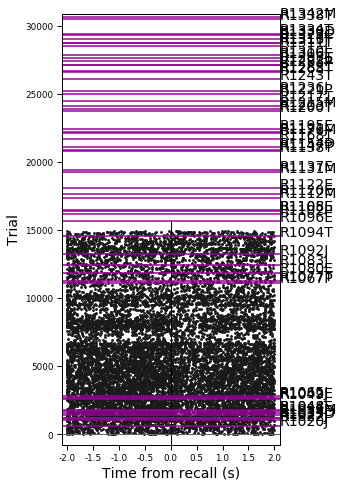

In [10]:

## for the raster and PSTH binarize the data by using the start indices of the ripple

save_raster = 0

elec_dividers_on = 0 # toggles light gray lines between electrodes
session_dividers_on = 0

dot_color = (0.1,0.1,0.1)
between_subject_color = (0.6,0,0.6)
between_session_color = (0,0.6,0.6)

encoding_whole_time = 1000*np.round(12*(1.6+0.875),1)

%autoreload
psth_start = -2000
psth_end = encoding_whole_time #2000

# plot raster
subplots(1,1,figsize=(8,20))   #y=100 for data cleaning # (4,6) for Fig. 4b # (4,10) for Fig. 2a
scatter(np.where(start_array)[1]*sr_factor+psth_start,np.where(start_array)[0],s=4,color=dot_color) # SWR time v. trial
xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,0.5))
xlabel('Time from recall (s)')
ylabel('Trial')
ax = plt.gca()
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]], linewidth=1,linestyle='-',color=(0,0,0))

last_sub = sub_names[0]
last_sess = sub_sess_names[0]
channels_per_session = []
trial_accum = 0
for s in range(1,len(trial_nums)):
    if (sub_names[s] != last_sub) | (s==1):
        if s != 1:
            # plot dark gray line between subjects
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=1.5,linestyle='-',color=between_subject_color)
            last_sub = sub_names[s]
            text(2100,0.5+np.sum(trial_nums[:s]),sub_names[s])
        else: 
            if session_dividers_on==1:
                # if 1st sub though gotta print that first gray line 
                plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.5,linestyle='-',color=between_session_color)
                text(2100,0,sub_names[s]) # and print 1st sub name at y=0
    else: # plot lines between electrodes
        if elec_dividers_on == 1:
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.5,linestyle='-',color=(.8,.8,.8))
    # plot lines between sessions
    if session_dividers_on==1:
        if sub_sess_names[s] != last_sess:
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.75,linestyle='-',color=between_session_color)
            last_sess = sub_sess_names[s]
            
    channels_per_session.append(np.unique(channel_nums_array[int(trial_accum):int(trial_accum+trial_nums[s])]))
    trial_accum = trial_accum+trial_nums[s]
    
plot([ax.get_xlim()[0],ax.get_xlim()[1]],-.5*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))        
plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums))*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))
ax.autoscale(enable=True, axis='y', tight=True)
plt.tight_layout()
# print('Total FR events: '+str(total_recalls)) # these were in whole retrieval period so not kept in usual ripple alignment
# print('Kept FR events: '+str(kept_recalls))
print(start_array.shape);
if save_raster == 1:
    if elec_dividers_on == 1:
        plt.savefig('../figures/rasters/'+exp+'_'+'raster_'+region_name+'_'+location_selected+
                    '-'+str(recall_type_switch)+'-'+filter_type+'.pdf',transparent=True)       
    else:
        plt.savefig('../figures/rasters/'+exp+'_'+'raster_'+region_name+'_'+location_selected+
                    '-'+str(recall_type_switch)+'no_elecs-'+filter_type+'.pdf',transparent=True)
a=1;

## Do we see more SWRs during successful encoding? (come here after loading 'encoding' and getting start_array)

In [84]:
# get start_array and masks to identify SME

desired_sample_rate = 500.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

# get vectors of encoding list identifier data for forgotten and recalled words
# in encoded_word_key_array, 0 for not recalled, 1 for recalled, 2 for recalled but was an IRI<2 (don't care about that for encoding)
master_key = encoded_word_key_array>0 # keep all recalls

start_array_enc_forgot = start_array[master_key==0]
start_array_enc_recalled = start_array[master_key==1]

# same for sub and sess
sub_forgot = np.array(subject_name_array)[master_key==0]
sess_forgot = np.array(session_name_array)[master_key==0]
sub_recalled = np.array(subject_name_array)[master_key==1]
sess_recalled = np.array(session_name_array)[master_key==1]

done making binned start_array with shape:
(14696, 26)
SEs created!
done making binned start_array with shape:
(38974, 26)
SEs created!
/home1/john/SWR/figures/ENCODING/SWR_FR1_HPC_ca1_0_soz_in_hamming_first_half.p
Test 1 p-value: 0.00026878368550786437
Test 2 p-value: 0.5855831061006906
53670 trials


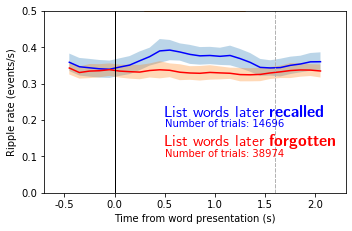

In [85]:
save_plot_data = 1

%autoreload
# get PSTH for recalled and then forgotten words. 
# Then bin it for the CIs and plot each
# then do ME stats on seleted bins and add significance bars if p<0.05

encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700

bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?

# for recalled and then forgotten words
for category in range(2):
    if category == 0:
        temp_start_array = start_array_enc_recalled
        subject_name_array = sub_recalled
        session_name_array = sess_recalled
        
        # for plot
        subplots(1,1,figsize=(5,4))
        label = 'List words later \\textbf{recalled}'
        plot_color = (0,0,1)
        text(500,0.21,label,usetex=True,size=16,color=plot_color)
        text(500,0.18,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)

    else:       
        temp_start_array = start_array_enc_forgot
        subject_name_array = sub_forgot
        session_name_array = sess_forgot
        
        # for plot
        label = 'List words later \\textbf{forgotten}'        
        plot_color = (1,0,0)
        text(500,0.13,label,usetex=True,size=16,color=plot_color) 
        text(500,0.10,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)
        
    # make a PSTH based on start times of SWRs

    PSTH,bin_centers = fullPSTH(temp_start_array,bin_size,smoothing_triangle,sr,pre_encoding_time)
    # bootstraps error bars by sampling from trials in raster with replacement samples number of
    # times and then taking the standard deviation across those samples
#     boot_samples = bootstrap(temp_start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
#                    bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,pre_encoding_time))
#     boot_SD = np.std(boot_samples,0)

    # get binned start array (trials X bins)
    binned_start_array = binBinaryArray(temp_start_array,bin_size,sr_factor)
    if pad > 0:
        binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
    print('done making binned start_array with shape:')
    print(binned_start_array.shape)

    # note that output is the net ± distance from mean
    SE_plot = getMixedEffectSEs(binned_start_array,subject_name_array,session_name_array)
    print('SEs created!')
    
    # plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    xr = xr[pad:-pad]; 
    
    plot(xr,PSTH[pad:-pad],color=plot_color)
    fill_between(xr, PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:], alpha = 0.3)
    xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
           np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
    xlabel('Time from word presentation (s)')
    ylabel('Ripple rate (events/s)')
    tight_layout()
    ax = plt.gca()
    ylim = 0.5
    ax.set_ylim(0,ylim)
    ax.set_xlim(pre_encoding_time,encoding_time)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
    plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))
    
    if category == 0:
        PSTH_recalled = copy(PSTH)
        SE_recalled = copy(SE_plot)
    else:
        PSTH_forgotten = copy (PSTH)
        SE_forgotten = copy(SE_plot)

# now that we have the plot with CIs, do stats on key bins. Note here just looking at single bins but comparing across categories
for test in range(2):
    if test == 0:
        first_start = 300
        first_end = 1300
    else:
        first_start = 1700 # same idea but for post-encoding period (ILI)
        first_end = 2300 
        
    bin_test_range = range(int( ((first_start-pre_encoding_time)/sr_factor) ),
                           int( ((first_end-pre_encoding_time)/sr_factor) ))
    binned_recalled_array = start_array_enc_recalled[:,bin_test_range]
    binned_forgot_array = start_array_enc_forgot[:,bin_test_range]
    
    stats_bin = int(first_end-first_start)
    binned_recalled_array = binBinaryArray(binned_recalled_array,stats_bin,sr_factor) # should be creating vectors for both
    binned_forgot_array = binBinaryArray(binned_forgot_array,stats_bin,sr_factor)
    
    bin_model = MEstatsAcrossCategories(binned_recalled_array,binned_forgot_array,
                                        sub_forgot,sess_forgot,sub_recalled,sess_recalled)
    
        # plot bands of significance
    if bin_model.pvalues[1] < 0.05:
        plot([first_end-stats_bin,first_end],[0.5,0.5],color=(1,0.5,0))
    
    if test == 0:
        bin_model1 = copy(bin_model)
        binned_recalled_array1 = copy(binned_recalled_array)
        binned_forgot_array1 = copy(binned_forgot_array)
    else:
        bin_model2 = copy(bin_model)
        binned_recalled_array2 = copy(binned_recalled_array)
        binned_forgot_array2 = copy(binned_forgot_array)
num_trials = len(master_key) 


# get directories for if you save (don't put this in save_plot_data below since want p-values printed at bottom close to figures)
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
path_name = '/home1/john/SWR/figures/'+subfolder

fn = os.path.join(path_name,
    'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                  '_'+filter_type+'_'+sub_selection+'.p') # -GT_5000.p' # -LT_5000.p' #'-intrusions.p'
print(fn)
print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
print('Test 2 p-value: '+str(bin_model2.pvalues[1]))
print(str(num_trials)+' trials')    
        
if save_plot_data == 1:
    # get strings for path name for save and loading cluster data
            
    if os.path.isdir(path_name) == False:
        os.mkdir(path_name)
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    with open(fn,'wb') as f:
        pickle.dump({'bin_centers':bin_centers,'PSTH_recalled':PSTH_recalled,'PSTH_forgotten':PSTH_forgotten,
                    'SE_recalled':SE_recalled,'SE_forgotten':SE_forgotten,'bin_model1':bin_model1,'bin_model2':bin_model2,
                    'binned_recalled_array1':binned_recalled_array1,'binned_forgot_array1':binned_forgot_array1,
                    'binned_recalled_array2':binned_recalled_array2,'binned_forgot_array2':binned_forgot_array2,
                    'subject_name_array':subject_name_array,'session_name_array':session_name_array,
                    'electrode_array':electrode_array,'channel_coords_array':channel_coords_array,
                    'master_key':master_key}, f) 
        # master_key is indicator for subsequently remembered and forgotten. Can get num_trials from it too
a=1;

## just to remake plot

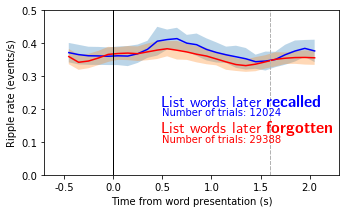

In [81]:
subplots(1,1,figsize=(5,3.375))

# for recalled and then forgotten words
for category in range(2):
    if category == 0:
        temp_start_array = start_array_enc_recalled
        subject_name_array = sub_recalled
        session_name_array = sess_recalled
        
        # for plot
        label = 'List words later \\textbf{recalled}'
        plot_color = (0,0,1)
        text(500,0.21,label,usetex=True,size=16,color=plot_color)
        text(500,0.18,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)
        
        PSTH = copy(PSTH_recalled)
        SE_plot = copy(SE_recalled)

    else:       
        temp_start_array = start_array_enc_forgot
        subject_name_array = sub_forgot
        session_name_array = sess_forgot
        
        # for plot
        label = 'List words later \\textbf{forgotten}'        
        plot_color = (1,0,0)
        text(500,0.13,label,usetex=True,size=16,color=plot_color) 
        text(500,0.10,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)
        
        PSTH = copy(PSTH_forgotten)
        SE_plot = copy(SE_forgotten)
        
    # plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    xr = xr[pad:-pad]; 
    PSTH = PSTH; #boot_SD = boot_SD[pad:-pad]
    plot(xr,PSTH[pad:-pad],color=plot_color)
    fill_between(xr, PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:], alpha = 0.3)
    xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
           np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
    xlabel('Time from word presentation (s)')
    ylabel('Ripple rate (events/s)')
    tight_layout()
    ax = plt.gca()
    ylim = 0.5
    ax.set_ylim(0,ylim)
    ax.set_xlim(pre_encoding_time,encoding_time)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
    plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))
a=1;


## encoding ripples by serial position

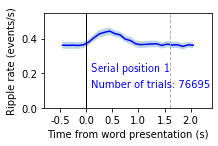

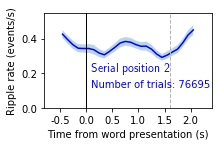

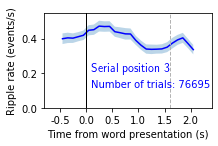

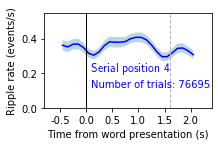

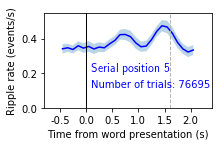

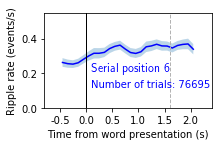

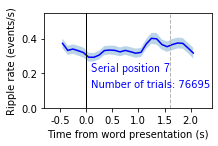

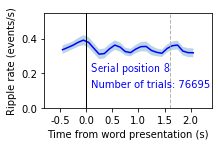

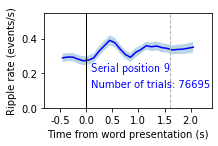

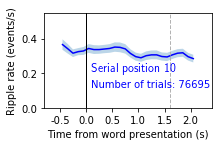

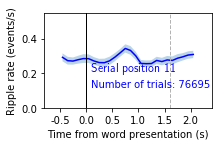

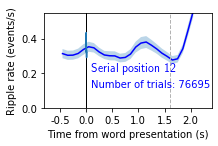

In [12]:
## plot recalled events by serial position

bin_range_to_compare = range(8,18) # this is 100:1100 ms 
# bin_range_to_compare = range(24,29) # this is 1700:2200 ms

binsize = 100 # in ms

ct = 0
serial_position_rem_rates = []
serial_position_rem_stds = []
position_rem_stds = []
serial_position_forgot_rates = []
serial_position_forgot_stds = []
tion_forgot_stds = []
num_recalled = []; num_forgot = []
for list_num in range(12):
    
    temp_start_array_rem = start_array_enc[(master_key==1) & (serial_positions==(list_num+1))]
    temp_start_array_forgot = start_array_enc[(master_key==0) & (serial_positions==(list_num+1))]
    
    subplots(1,1,figsize=(3,1.75))
    label = 'Serial position '+str(list_num+1)
    plot_color = (0,0,1)
    text(100,0.21,label,usetex=True,size=12,color=plot_color)
    text(100,0.12,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)
    ct+=temp_start_array.shape[0]    
    # make a PSTH based on start times of SWRs

    PSTH,bin_centers = fullPSTH(temp_start_array_rem,binsize,smoothing_triangle,sr,pre_encoding_time)
    PSTH_forgot,bin_centers = fullPSTH(temp_start_array_forgot,binsize,smoothing_triangle,sr,pre_encoding_time)
    
    # bootstraps error bars by sampling from trials in raster with replacement samples number of
    # times and then taking the standard deviation across those samples
    boot_samples = bootstrap(temp_start_array_rem, bootnum=samples, samples=None, # bootstrap error bars using resampling
                   bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,pre_encoding_time))
    boot_SD = np.std(boot_samples,0)
    
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    
    # plot
    plot(xr[pad:-pad],PSTH[pad:-pad],color=plot_color)
    fill_between(xr[pad:-pad], (PSTH+boot_SD)[pad:-pad], (PSTH-boot_SD)[pad:-pad], alpha = 0.3)
    xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
           np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
    xlabel('Time from word presentation (s)')
    ylabel('Ripple rate (events/s)')
    ax = plt.gca()
    ylim = 0.55
    ax.set_ylim(0,ylim)
    ax.set_xlim(pre_encoding_time-100,encoding_time+100)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0));
    plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7));
#     plot([ax.get_xlim()[0],ax.get_xlim()[1]],[0.4,0.4],linewidth=1,linestyle='--',color=(0.5,0.5,0.5));

    # save data for full serial position plot below
    serial_position_rem_rates.append(np.mean(PSTH[bin_range_to_compare]))
    serial_position_rem_stds.append(np.std(PSTH[bin_range_to_compare]))
    serial_position_forgot_rates.append(np.mean(PSTH_forgot[bin_range_to_compare]))
    serial_position_forgot_stds.append(np.std(PSTH_forgot[bin_range_to_compare]))
    num_recalled.append(temp_start_array_rem.shape[0])
    num_forgot.append(temp_start_array_forgot.shape[0])
plot(serial_position_rem_rates)    
a=1;

In [ ]:
# create the general figure
fig1 = figure()
 
# and the first axes using subplot populated with data 
ax1 = fig1.add_subplot(111)

xr=np.arange(1,13)
line1 = errorbar(xr,serial_position_rem_rates,serial_position_rem_stds) 
line2 = errorbar(xr,serial_position_forgot_rates,serial_position_forgot_stds)
xticks(xr,xr)
ax1.set_ylim(0,ylim)
xlabel('List serial position')
ylabel('Mean ripple rate (events/s)')
if bin_range_to_compare == range(8,18):
    title('Ripple rate 100-1100 ms after word presentation')
elif bin_range_to_compare == range(24,29): 
    title('Ripple rate 1700-2200 ms after word presentation')
    
# now, the second axes that shares the x-axis with the ax1
ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
line3 = ax2.plot(xr,num_recalled, 'xr-')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylim(0,3500)
ylabel("Recalls (#)")

ax1.legend((line1,line2),("Words later remembered","Words later forgotten"))
ax2.legend(line3,{"Number of recalls"},loc='lower right')
 
# for the legend, remember that we used two different axes so, we need 
# to build the legend manually
# legend((line1, line2), ("1", "2"))
show();